28104
28079
1944
26135
<class 'pandas.core.frame.DataFrame'>
Index: 26135 entries, 0 to 106088
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   city         26135 non-null  object  
 1   address      26135 non-null  object  
 2   area         26135 non-null  float64 
 3   floor        26135 non-null  object  
 4   name         26135 non-null  object  
 5   price        26135 non-null  float64 
 6   province     26135 non-null  object  
 7   rooms        26135 non-null  object  
 8   toward       26135 non-null  category
 9   unit         26135 non-null  float64 
 10  year         26135 non-null  int32   
 11  district     26135 non-null  object  
 12  floor_type   26135 non-null  category
 13  floor_type2  26135 non-null  category
dtypes: category(3), float64(3), int32(1), object(7)
memory usage: 2.4+ MB
  city                       address   area     floor    name  price province  \
0   合肥            龙岗-临泉东路和王岗

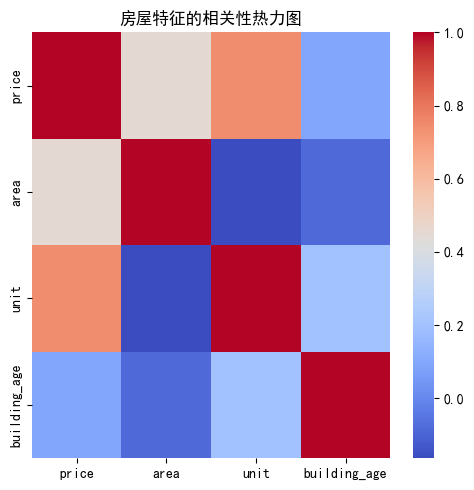

In [ ]:
# 1. 导入库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'SimHei'

# 2. 导入数据
df = pd.read_csv('./data/house_sales.csv')

# 3. 数据概览
# print(f'总记录数：{len(df)}')
# print(f'列数：{len(df.columns)}')
# print(df.head())
# print(df.info())

# 4. 数据清洗
# 4.1 删除无用的列 url不用
df.drop(columns='origin_url', inplace=True)
# print(df.info())

# 4.2 处理缺失值
# print(df.isna().sum())
# 数据比较多，删掉不要紧
df.dropna(inplace=True)
# print(len(df))
# print(df.isna().sum())

# 4.3 检查是否有重复值
# print(df.duplicated().sum())
# 删除重复数据
df.drop_duplicates(inplace=True)
print(len(df))

# 4.4 数据类型转换

# 4.4.1 area
# print(df.head())
# .str字符串选择器
df['area'] = df['area'].str.replace('㎡', '').astype(float)

# 4.4.2 price
df['price'] = df['price'].str.replace('万', '').astype(float)

# 4.4.3 toward
# print(df['toward'].value_counts())
df['toward'] = df['toward'].astype('category')

# 4.4.4 unit
df['unit'] = df['unit'].str.replace('元/㎡', '').astype(float)

# 4.4.5 year
df['year'] = df['year'].str.replace('年建', '').astype(int)
# print(df.head(2))
# print(df.info())

# 4.5 异常值处理
# 4.5.1 去掉面积过大与过小的 == 选择中间的
df = df[(df['area']<600) & (df['area']>20)]
print(len(df))

# 4.5.2 用IQR去掉异常的
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
low_price  = Q1 - 1.5 * IQR
high_price = Q3 + 1.5 * IQR
print(len(df[(df['price']<low_price) | (df['price']>high_price)]))
# 当然不一定符合IQR规律，所以不一定去掉
df = df[(df['price']>=low_price) & (df['price']<=high_price)]
print(len(df))

# 5. 数据特征构造，构造特征回答问题

# 地区
df['district'] = df['address'].str.split('-').str[0] # str再变一下


# 楼层
# 法1：字符串
df['floor_type'] = df['floor'].str.split('（').str[0].astype('category') # str再变一下

# 法2：函数
def fun1(str1):
    if pd.isna(str1):
        return '未知'
    elif '低' in str1:
        return '低楼层'
    elif '中' in str1:
        return '中楼层'
    elif '高' in str1:
        return '高楼层'
    else:
        return '未知'
    # print(str1)

df['floor_type2'] = df['floor'].apply(fun1).astype('category')
df.info()
# print(df.head())

# 是否直辖市zxs
# 仍然是函数式写
def fun2(str2):
    # print(str2)
    if str2 in ['北京', '上海', '天津', '重庆']:
        return True
    else:
        return False
df['zxs'] = df['city'].apply(fun2)

df['city'].apply(lambda x: True if x in ['北京', '上海', '天津', '重庆'] else False) # 匿名函数也行

# 卧室数量
df['bedrooms'] = df['rooms'].str.split('室').str[0].astype(int)

# 客厅数量
# 法1：很麻烦
df['livingrooms'] = df['rooms'].str.split('室').str[1].str.split('厅').str[0].astype(int)
# 法2：正则表达式
df['livingrooms'] = df['rooms'].str.extract(r'(\d+)厅').astype(int)

# 年份
df['building_age'] = 2025 - df['year']

# 价格分段
df['price_labels'] = pd.cut(df['price'], bins=4, labels=['低价', '中价', '高价', '豪华'])
print(df.head())


# 6. 问题分析及可视化

# A1 哪些变量最影响房价？面积、楼层、房间数哪个影响更大？
# 了解房屋各特征对房价的线性影响
# 皮尔逊相关系数

# 选择数字型特征
a = df[['price', 'area', 'unit', 'building_age']].corr()
# 对房价的影响最大的几个因素排序
a['price'].sort_values(ascending=False)[1:]
# 相关性热力图
plt.figure(figsize=(5, 5))
sns.heatmap(a, cmap='coolwarm')
plt.title('房屋特征的相关性热力图')
plt.tight_layout()



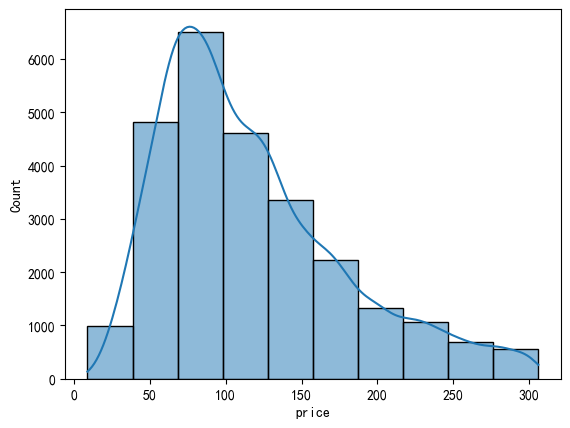

In [84]:
# A2全国房价总体分布式怎样的？是否存在极端值？
# 描述性统计
# 概览数值型字段的分布特征
# 平均数/中位数/四分位数/标准差
df.describe()
# 房价分布直方图
plt.subplot(111)
# plt.hist(df['price'], bins=10)
# 或者
sns.histplot(df, x='price', bins=10, kde=True)
plt.show()

C:\Users\XPH\AppData\Local\Temp\ipykernel_9076\1384733848.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('toward').agg({


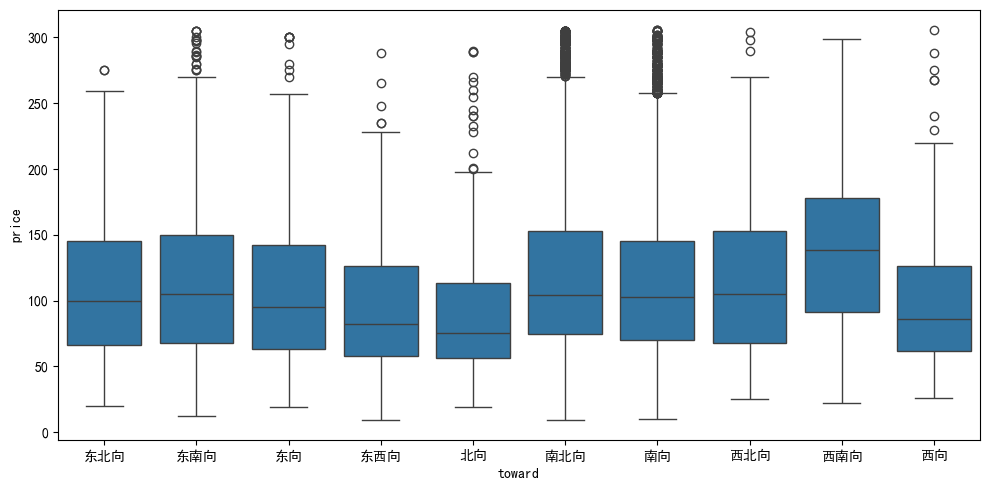

In [87]:
# A6南北向是否真比单一朝向贵？贵多少
# 朝向溢价	评估不同朝向的价格差异
# toward
# 方差分析/多重比较
df['toward'].value_counts()
df.groupby('toward').agg({
    'price': ['mean', 'median'],
    'unit': 'median',
    'building_age': 'mean'
})

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='toward', y='price')
plt.tight_layout()
